# 2023.05.24 MFCC
Dataset Info.

train [폴더]

    학습을 위한 소리 샘플
    TRAIN_0000.wav ~ TRAIN_5000.wav


test [폴더]

    추론을 위한 소리 샘플
    TEST_0000.wav ~ TEST_1880.wav


train.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로
    label : 감정의 종류
    0: angry
    1: fear
    2: sad
    3: disgust
    4: neutral
    5: happy


test.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로


sample_submission.csv [파일] - 제출 양식

    id : 샘플 별 고유 ID
    label : 예측한 감정의 종류


This Crowd-sourced Emotional Mutimodal Actors Dataset (CREMA-D) is made available under the Open Database License: 

http://opendatacommons.org/licenses/odbl/1.0/. 

Any rights in individual contents of the database are licensed under the Database Contents License: 

http://opendatacommons.org/licenses/dbcl/1.0/



In [326]:
file_dir = '데이콘 음성 감정 인식'

In [327]:
import pandas as pd

train_df = pd.read_csv(file_dir + '/train.csv')
test_df = pd.read_csv(file_dir + '/test.csv')

In [328]:
train_df['path'] = [i.replace('./train', file_dir+'/train') for i in train_df['path']]

In [329]:
test_df['path'] = [i.replace('./test', file_dir+'/test') for i in test_df['path']]

In [330]:
#!pip install librosa --user librosa깔 때는 꼭 이거쓰기!!

In [331]:
import numpy as np
import pandas as pd
import os
import librosa
#import librosa.display <<이새끼가 matplotlib이랑 충돌 남
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = { 0: 'angry'
			,1: 'fear'
			,2: 'sad'
			,3: 'disgust'
			,4: 'neutral'
			,5: 'happy'}
SAMPLE_RATE = 48000

In [332]:
print("number of files is {}".format(len(train_df)))

number of files is 5001


In [333]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [334]:
EMOTIONS[0]

'angry'

In [335]:
def relabel(x):
    return EMOTIONS[x]

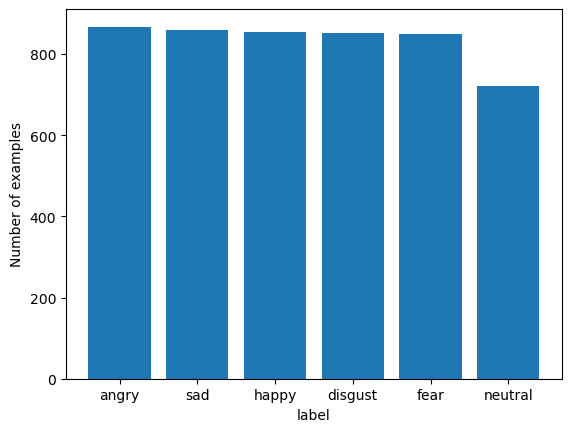

In [336]:
#%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
counts = train_df['label'].value_counts()
ax.bar(x=[relabel(i) for i in list(counts.index)], height=counts.values)
ax.set_xlabel('label')
ax.set_ylabel('Number of examples')
plt.show()

In [337]:
#!pip install python_speech_features

In [338]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Time Series', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Fourier Transform', size = 16, position = (0.5, 1.2))
    i = 0
    i = 0
    for y in range(6):
        data = list(fft.values())[i]
        Y,freq = data[0], data[1]        
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(freq, Y)
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Filter Bank Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(fbank.values())[i],
                     cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1
            
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(mfccs.values())[i],
                        cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1


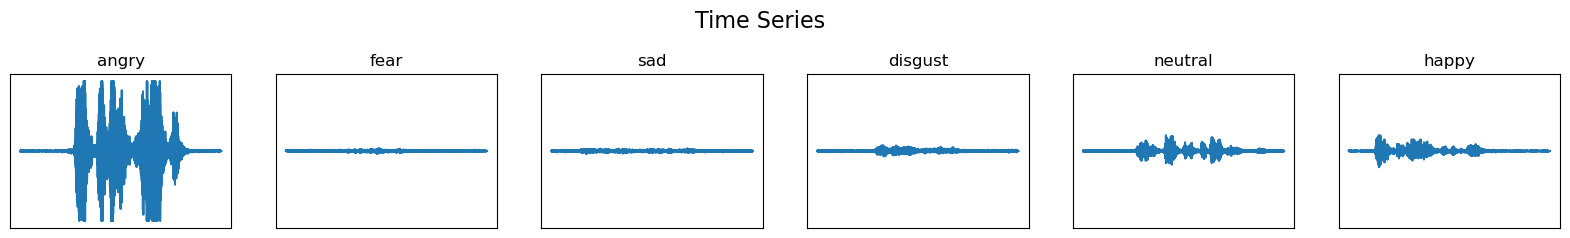

In [339]:
from python_speech_features import mfcc, logfbank

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

classes = list(np.unique(train_df.label))


signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr=16000)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 400).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 400).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


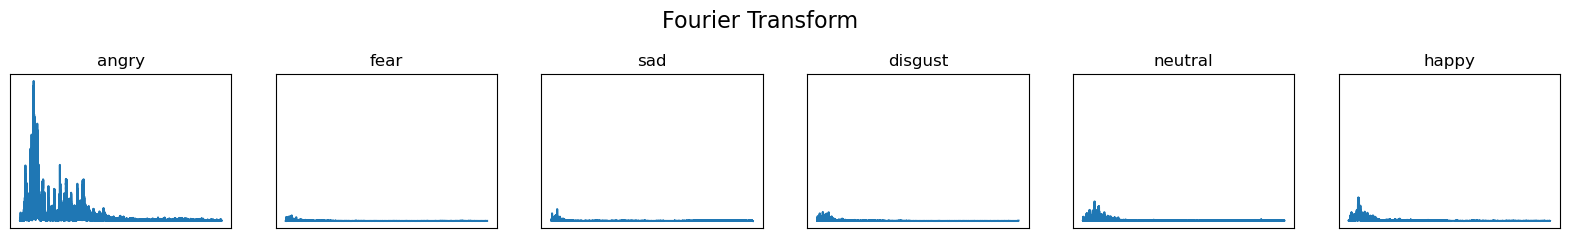

In [340]:
plot_fft(fft)
plt.show()

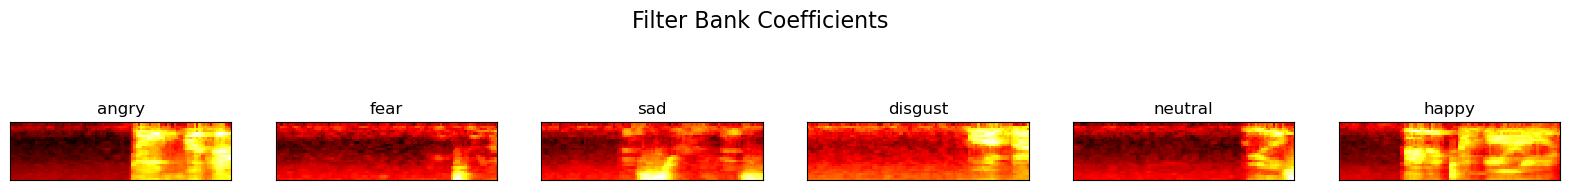

In [341]:
plot_fbank(fbank)
plt.show()

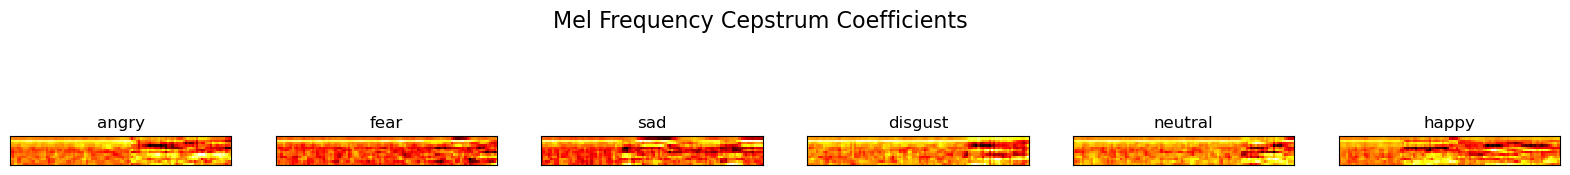

In [342]:
plot_mfccs(mfccs)
plt.show()

In [343]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/40), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


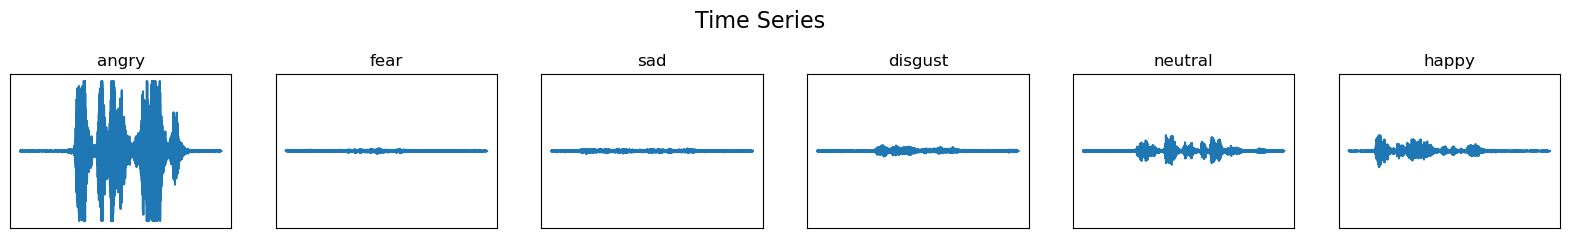

In [344]:
for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr = 16000)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 400).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 400).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


In [345]:
#!unzip -uq "train.zip" -d "데이콘 음성 감정 인식/train" #이렇게 받으면 안에 파일이 풀리니 꼭! 폴더에 지정!

In [346]:
#!unzip -uq "test.zip" -d "test"

In [347]:
import seaborn as sns
import wave

# 오디오 프레임 수를 반환
train_df['nframes'] = train_df['path'].apply(lambda f: wave.open(f).getnframes())
test_df['nframes'] = test_df['path'].apply(lambda f: wave.open(f).getnframes())


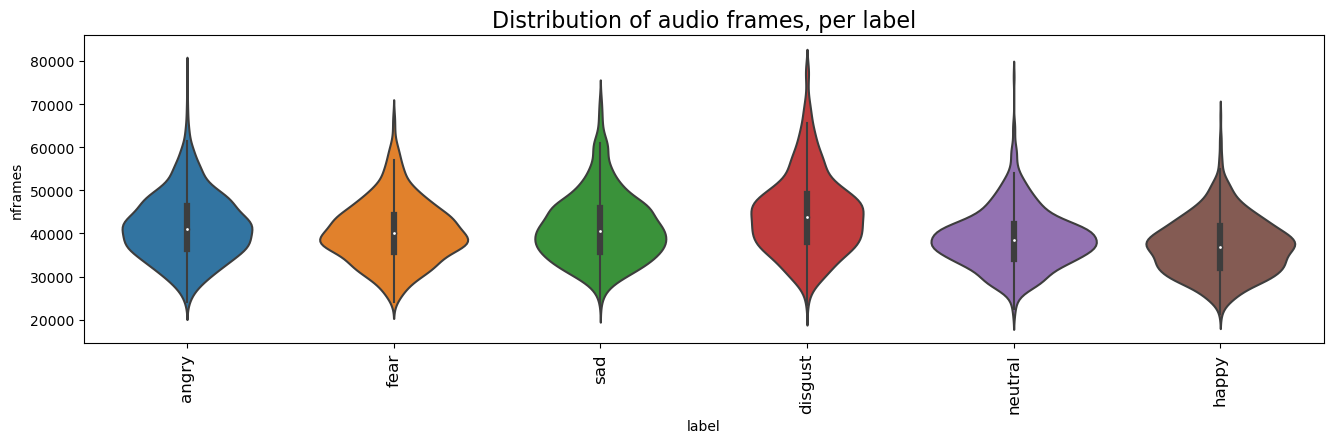

In [348]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train_df)
plt.xticks(rotation=90)
ax.set_xticklabels([relabel(i) for i in train_df.label.drop_duplicates().sort_values()], fontsize=12)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()


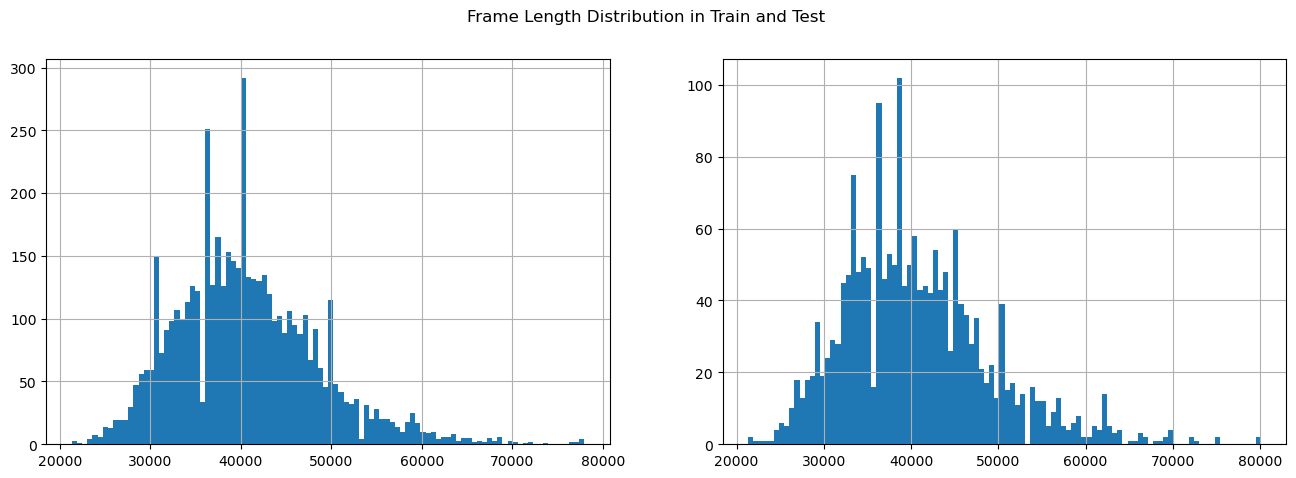

In [349]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train_df.nframes.hist(bins=100, ax=axes[0])
test_df.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

In [350]:
import torchaudio

In [351]:
import torch
from tqdm import tqdm
audio_files = []
for i in tqdm(list(train_df.path)):
    i, _ = torchaudio.load(i)
    audio_files.append(i)


100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:00<00:00, 8625.65it/s]


In [352]:
maxlen = 0
minlen = np.Inf
for i in audio_files:
    if i.shape[1]>maxlen:
        maxlen = i.shape[1]
    if i.shape[1]<minlen:
        minlen = i.shape[1]

In [353]:
minlen, maxlen

(21355, 77945)

In [354]:
#스펙트로그램 변환
spectrograms = []
for i in audio_files:
    specgram = torchaudio.transforms.Spectrogram()(i)
    spectrograms.append(specgram)


In [355]:
max_width, max_height = max([i.shape[2] for i in spectrograms]), max([i.shape[1] for i in spectrograms])


In [356]:
import torch.nn.functional as F

image_batch = [
    # The needed padding is the difference between the
    # max width/height and the image's actual width/height.
    F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
    for img in spectrograms
]


In [357]:
del audio_files, spectrograms


In [358]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(113) # Seed 고정

In [359]:
#!pip install fastai

In [360]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile as wav
import numpy as np
from numpy.lib import stride_tricks

In [361]:
sr = 16000
n_fft = int(np.ceil(0.025*sr))
win_length = int(np.ceil(0.025*sr))
hop_length = int(np.ceil(0.01*sr))
n_mels = 64
print(f'n_fft = {n_fft}')
print(f'win_length = {win_length}')
print(f'hop_length = {hop_length}')

n_fft = 400
win_length = 400
hop_length = 160


In [362]:
class conf:
    # Preprocessing settings
    sampling_rate = sr
    duration = 2
    hop_length = hop_length
    fmin = 0
    fmax = sampling_rate // 2
    n_mels = n_fft/20
    n_fft = n_fft
    samples = sampling_rate * duration
    n_mfcc = 30

In [419]:
import scipy
import warnings
warnings.filterwarnings('ignore')

def feature_engineering(df, gb, n = 10):    
    
    n_samples = df['path'].shape[0]
    df['zero_crossing_rate'] = np.zeros(n_samples)
    df['chroma_stft'] = np.zeros(n_samples)
    df['rmse'] = np.zeros(n_samples)
    df['spectral_centroid'] = np.zeros(n_samples)
    df['spectral_bandwidth'] = np.zeros(n_samples)
    df['beat_per_minute'] = np.zeros(n_samples)
    df['rolloff'] = np.zeros(n_samples)
    for i in range(0, conf.n_mfcc):
        df[f'mfcc_{i}'] = np.zeros((n_samples))    
        df[f'delta_mfcc_{i}'] = np.zeros((n_samples))
    
    for i in tqdm(range(n_samples)):
    #for path in tqdm(df['path']):
        y, sr = librosa.load(df['path'][i], sr=conf.sampling_rate)
        df['rmse'][i] = np.mean(librosa.feature.rms(y=y))
        df['chroma_stft'][i] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        df['spectral_centroid'][i] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        df['spectral_bandwidth'][i] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        df['rolloff'][i] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        df['zero_crossing_rate'][i] = np.mean(librosa.feature.zero_crossing_rate(y))
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        df['beat_per_minute'] = tempo
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=conf.n_mfcc)
    
        delta_mfcc  = librosa.feature.delta(mfcc)
        
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e,d in zip(range(0, conf.n_mfcc), range(0, conf.n_mfcc)):
            df[f'mfcc_{e}'][i] = np.mean(mfcc[e])
            df[f'delta_mfcc_{d}'][i] = np.mean(mfcc[d])
    if gb == 'train':
        df = pd.merge(df, train_df[['nframes']], left_index = True, right_index = True, how = 'left')
    else:
        df = pd.merge(df, test_df[['nframes']], left_index = True, right_index = True, how = 'left')
        
    # 라벨을 제외한 수치형 컬럼만
    for i in tqdm(df.select_dtypes(include=[float,int]).columns.tolist()):
        df[f'{i}_mean'] = df[[i]].mean(axis=1)
        df[f'{i}_min'] = df[[i]].min(axis=1)
        df[f'{i}_max'] = df[[i]].max(axis=1)
        df[f'{i}_median'] = df[[i]].median(axis=1)
    return df

In [420]:
X_fn = feature_engineering(train_df.drop(columns =['id','label']), gb = 'train')
X_test_fn = feature_engineering(test_df.drop(columns =['id']), gb = 'test')

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 262.24it/s]


In [421]:
X_fn = X_fn.drop(columns = ['path'])
X_test_fn = X_test_fn.drop(columns = ['path'])

In [422]:
y = train_df['label']

In [369]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dataset_transformed = scaler.fit_transform(X_fn)
X_fn = pd.DataFrame(dataset_transformed, columns=X_fn.columns)

dataset_transformed = scaler.transform(X_test_fn)
X_test_fn = pd.DataFrame(dataset_transformed, columns=X_test_fn.columns)

In [423]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_fn, y, train_size=0.8, shuffle=True, random_state=113)

In [443]:
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(random_seed = 113,
                          task_type='GPU',                      
                          bootstrap_type = 'Poisson',
                          loss_function='MultiClass',
                          eval_metric = 'Accuracy',
                          #l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          #learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          iterations =  10000,
                          early_stopping_rounds = 100,                           
                          verbose=1000
                          )

In [ ]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )

Learning rate set to 0.044222
0:	learn: 0.5597500	test: 0.3436563	best: 0.3436563 (0)	total: 448ms	remaining: 1h 14m 37s


In [ ]:
y_test_pred =  fit_model.predict(X_test_fn[X_valid.columns])

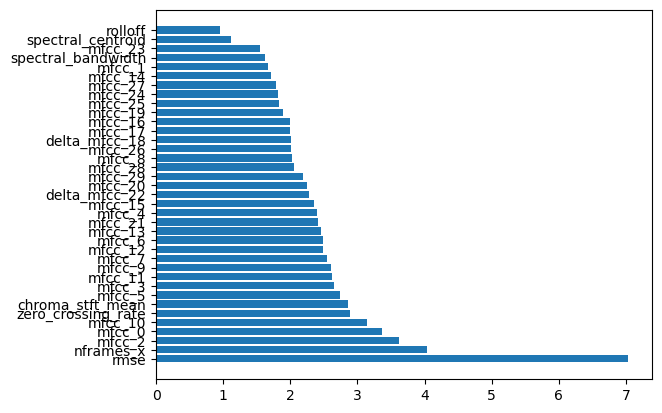

In [431]:
cat_importance_feature = np.argsort(fit_model.feature_importances_)[:-38:-1]
plt.barh(X_fn.columns[cat_importance_feature], fit_model.feature_importances_[cat_importance_feature])
plt.show()

In [432]:
impt_features = X_fn.columns[cat_importance_feature].tolist()

In [433]:
from sklearn.model_selection import train_test_split
X_fn_ft = X_fn[impt_features]
y = y

X_train, X_valid, y_train, y_valid = train_test_split(X_fn_ft, y, train_size=0.8, shuffle=True, random_state=113)

In [ ]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )

Learning rate set to 0.044222
0:	learn: 0.4270000	test: 0.4075924	best: 0.4075924 (0)	total: 8.19ms	remaining: 1m 21s
1000:	learn: 0.9600000	test: 0.5154845	best: 0.5194805 (992)	total: 8.27s	remaining: 1m 14s
2000:	learn: 1.0000000	test: 0.5134865	best: 0.5254745 (1525)	total: 16.4s	remaining: 1m 5s
3000:	learn: 1.0000000	test: 0.5264735	best: 0.5284715 (2833)	total: 25.2s	remaining: 58.7s
4000:	learn: 1.0000000	test: 0.5224775	best: 0.5294705 (3105)	total: 33.9s	remaining: 50.8s
5000:	learn: 1.0000000	test: 0.5204795	best: 0.5294705 (3105)	total: 42.3s	remaining: 42.3s
6000:	learn: 1.0000000	test: 0.5194805	best: 0.5294705 (3105)	total: 50.9s	remaining: 33.9s


KeyboardInterrupt: 

In [408]:
y_test_pred =  fit_model.predict(X_test_fn[X_valid.columns])

In [409]:
sub = pd.DataFrame()
sub['id'] = X_test['id']
sub['label'] = y_test_pred
sub

,id,label
0,TEST_0000,5
1,TEST_0001,0
2,TEST_0002,2
3,TEST_0003,3
4,TEST_0004,5
...,...,...
1876,TEST_1876,0
1877,TEST_1877,5
1878,TEST_1878,0
1879,TEST_1879,2


[Text(0, 0, 'angry'),
 Text(1, 0, 'fear'),
 Text(2, 0, 'sad'),
 Text(3, 0, 'disgust'),
 Text(4, 0, 'neutral'),
 Text(5, 0, 'happy')]

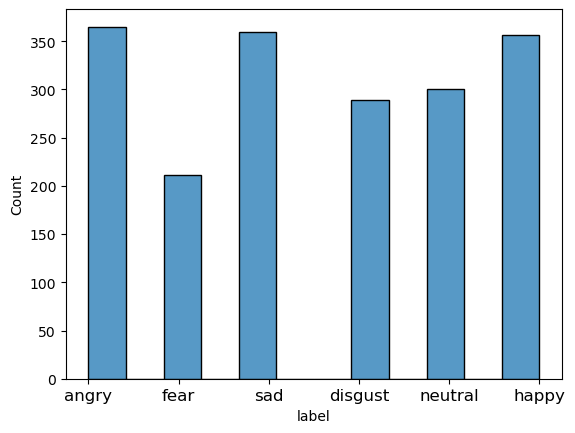

In [410]:
import seaborn as sns
h = sns.histplot(sub['label'])
h.set_xticks(range(len(train_df.label.drop_duplicates().sort_values())))
h.set_xticklabels([relabel(i) for i in train_df.label.drop_duplicates().sort_values()], fontsize=12)

In [411]:
sub.to_csv('23.05.24 mfcc_cat(2).csv', index=False,encoding="utf-8-sig")